# AdaGrad算法

## 稀疏特征和学习率
## 预处理

## 算法

$$\begin{aligned}
    \mathbf{g}_t & = \partial_{\mathbf{w}} l(y_t, f(\mathbf{x}_t, \mathbf{w})), \\
    \mathbf{s}_t & = \mathbf{s}_{t-1} + \mathbf{g}_t^2, \\
    \mathbf{w}_t & = \mathbf{w}_{t-1} - \frac{\eta}{\sqrt{\mathbf{s}_t + \epsilon}} \cdot \mathbf{g}_t.
\end{aligned}$$

在这里，操作是按照坐标顺序应用。
也就是说，$\mathbf{v}^2$有条目$v_i^2$。
同样，$\frac{1}{\sqrt{v}}$有条目$\frac{1}{\sqrt{v_i}}$，
并且$\mathbf{u} \cdot \mathbf{v}$有条目$u_i v_i$。
与之前一样，$\eta$是学习率，$\epsilon$是一个为维持数值稳定性而添加的常数，用来确保我们不会除以$0$。
最后，我们初始化$\mathbf{s}_0 = \mathbf{0}$。

我们仍然以同一函数为例：

$$f(\mathbf{x}) = 0.1 x_1^2 + 2 x_2^2.$$

我们将使用与之前相同的学习率来实现AdaGrad算法，即$\eta = 0.4$。
可以看到，自变量的迭代轨迹较平滑。
但由于$\boldsymbol{s}_t$的累加效果使学习率不断衰减，自变量在迭代后期的移动幅度较小。


In [1]:
%matplotlib inline
import math
import torch
from d2l import torch as d2l

epoch 20, x1: -2.382563, x2: -0.158591


e:\Anaconda3\envs\DL\lib\site-packages\torch\functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


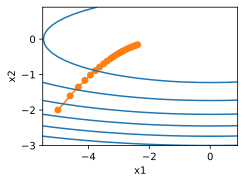

In [2]:
def adagrad_2d(x1, x2, s1, s2):
    eps = 1e-6 # 防止除零错误的小常数
    '''
    计算当前梯度
    来自目标函数f(x_{1},x_{2})=0.1x_{1}^{2}+2x_{2}^{2}
    梯度：∇f=(0.2x_{1},4x_{2}) 
    '''
    g1, g2 = 0.2 * x1, 4 * x2
    '''
    累计梯度平方和
    s1,s2是每个参数的历史梯度能量累积
    频繁更新的参数（梯度大）：s增长快→学习率自动减小
    稀疏更新的参数（梯度小）：s增长慢→学习率保持较大
    '''
    s1 += g1 ** 2
    s2 += g2 ** 2
    '''
    自适应更新
    有效学习率：η/sqrt{​s_{i}+ϵ​}
    x₂方向：梯度大→s2大→学习率快速衰减→避免震荡
    x₁方向：梯度小→s1小→学习率保持较大→加速收敛
    '''
    x1 -= eta / math.sqrt(s1 + eps) * g1
    x2 -= eta / math.sqrt(s2 + eps) * g2
    return x1, x2, s1, s2
# 目标函数
# 条件数：κ=λ_{max}/λ_{min}=4/0.2=20 ;梯度差异：x₂方向梯度是x₁方向的20倍
def f_2d(x1, x2):
    return 0.1 * x1 ** 2 + 2 * x2 ** 2
# 学习率：相对较大的0.4;AdaGrad特性：学习率会被自动调整，不怕过大
eta = 0.4
'''
        标准GD (eta=0.4)               AdaGrad (eta=0.4)
  ┌──────────────────────┐        ┌──────────────────────┐
  │                      │        │                      │
  │   ●━━━●━━━●━━━●      │        │   ●─────●─────●      │
  │ ╱                    │        │ ╲                    │
  │╱                     │        │  ╲                   │
  │                      │        │   ╲                  │
  └──────────────────────┘        └──────────────────────┘
   锯齿状，效率低                  平滑，直指最优解
AdaGrad的优势：
初期：x₂方向梯度大，学习率自动衰减，避免过大步长
后期：x₁方向学习率相对较大，加速平缓方向的收敛
整体：路径更直接，条件数问题被缓解
'''
d2l.show_trace_2d(f_2d, d2l.train_2d(adagrad_2d))

我们将学习率提高到$2$，可以看到更好的表现。
这已经表明，即使在无噪声的情况下，学习率的降低可能相当剧烈，我们需要确保参数能够适当地收敛。


epoch 20, x1: -0.002295, x2: -0.000000


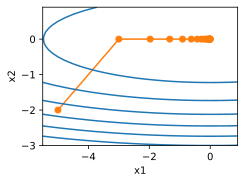

In [3]:
eta = 2
d2l.show_trace_2d(f_2d, d2l.train_2d(adagrad_2d))

## 从零开始实现

| 变量    | 实际形状               | 原因               |
| ----- | ------------------ | ---------------- |
| `w`   | `(feature_dim, 1)` | 权重矩阵（列向量）        |
| `s_w` | `(feature_dim, 1)` | **匹配 `w`**，逐元素累积 |
| `b`   | `(1,)`             | 偏置标量（张量化）        |
| `s_b` | `(1,)`             | **匹配 `b`**，逐元素累积 |


**执行流程：**<br>

**步骤1：设置数值稳定常数**
```Python
eps = 1e-6 # 防止分母 sqrt(s) 接近0时发生除零错误或数值爆炸
```
**步骤2：遍历参数和状态**
```Python
for p, s in zip(params, states):
p：单个参数张量（如权重 w 或偏置 b）
s：对应参数的累积梯度平方和缓存
```
**步骤3：禁用梯度追踪**
```Python
with torch.no_grad():
```
必要性：原地修改s和p不应被PyTorch自动求导系统追踪<br>
避免：破坏计算图或引发"需要grad的张量被修改"的错误<br>

**步骤4：累积梯度平方和**
```Python
s[:] += torch.square(p.grad)
```
**数学**：$s_{t}=s_{t−1}+(∇p_{t})^2$<br>
- s[:]：原地赋值，修改s的内容但保持其内存地址不变（维持states中的引用）
- torch.square(p.grad)：逐元素平方当前梯度
- 效果：s是从训练开始至今 的所有梯度平方的累加和

**步骤5：自适应更新参数**
```Python
p[:] -= hyperparams['lr'] * p.grad / torch.sqrt(s + eps)
```
**数学**：$θ_{t}=θ_{t−1}−\frac{η}{s_{t}+ϵ} \cdot ∇p_{t}$<br>

**有效学习率：** $\frac{η}{s_{t}+ϵ}$，随时间递减<br>
**自适应机制**：<br>
**频繁更新的参数**（梯度大）：s 增长快 → 学习率自动减小 → 避免震荡<br>
**稀疏更新的参数**（梯度小）：s 增长慢 → 学习率保持较大 → 加速收敛<br>

**步骤6：梯度清零**
```Python
p.grad.data.zero_()
```
**必要性**：PyTorch梯度默认累加，不清零会导致下次迭代时梯度叠加
**📊 形状与广播机制**
```Python
# 假设
p = w  # shape: (5, 1)
s = s_w  # shape: (5, 1)
grad = p.grad  # shape: (5, 1)

# 运算过程
torch.square(grad)  # shape: (5, 1)
s[:] += ...         # 逐元素相加
torch.sqrt(s + eps) # shape: (5, 1)
p.grad / (s + eps)  # 逐元素相除（广播）
```
**⚠️ AdaGrad的缺陷与改进**
**缺陷：**
```Python
s[:] += torch.square(p.grad)  # s 只增不减
# 长期训练 → s → ∞ → 学习率 → 0 → 训练提前停止
```
**改进方案：**
| 算法                 | 核心改进         | 公式                                                                                                       |
| ------------------ | ------------ | -------------------------------------------------------------------------------------------------------- |
|  RMSProp   | 指数移动平均       | $s_t = \beta s_{t-1} + (1-\beta) (\nabla p_t)^2$                                                         |
|  AdaDelta | 无需学习率        | $\Delta \theta = -\frac{\sqrt{s_{\Delta, t-1} + \epsilon}}{\sqrt{s_t + \epsilon}} \nabla p_t$            |
|  Adam      | 动量 + RMSProp | $m_t = \beta_1 m_{t-1} + (1-\beta_1) \nabla p_t$<br>$s_t = \beta_2 s_{t-1} + (1-\beta_2) (\nabla p_t)^2$ |

In [4]:
'''
为每个参数创建累积梯度平方和的缓存（初始化为0）
状态结构：
s_w：权重矩阵的梯度平方和缓存，形状与w一致(feature_dim,1)
s_b：偏置向量的梯度平方和缓存，形状与b一致(1,)
返回：元组(s_w,s_b)，与参数列表params一一对应
'''
def init_adagrad_states(feature_dim):
    s_w = torch.zeros((feature_dim, 1))
    s_b = torch.zeros(1)
    return (s_w, s_b)

def adagrad(params, states, hyperparams):
    eps = 1e-6 # 防止除零的小常数
    '''
    遍历 参数列表params和状态列表states
    p：单个参数张量（如权重w或偏置b）
    s：对应参数的累积梯度平方和缓存
    zip确保每个参数与其状态一一配对
    '''
    for p, s in zip(params, states):
        with torch.no_grad():
            '''
            功能：累加当前梯度的平方到状态缓存 s
            数学：s_{t}=s_{t−1}+(∇p_{t})^2
            s[:]：原地切片赋值，修改s的内容但不改变其内存地址,保持states对s的引用不变
            若不使用[:]，会创建新张量，导致states中的引用失效
            torch.square(p.grad)：逐元素平方梯度
            '''
            s[:] += torch.square(p.grad)
            '''
            功能：用自适应学习率更新参数 p
            数学：p_{t}=p_{t−1}−η/ \srrt{s_{t}+ϵ}⋅∇p_{t}
            p[:]：原地更新参数值
            自适应学习率：\sqrt {η/s_{t}+ϵ}
            频繁更新参数（梯度大）→s_t 大→学习率自动减小
            稀疏更新参数（梯度小）→s_t 小→学习率保持较大
            解决不同维度收敛速度不一致的问题
            eps=1e-6：防止除零错误

            '''
            p[:] -= hyperparams['lr'] * p.grad / torch.sqrt(s + eps)
        p.grad.data.zero_()

| 参数                | 值                                  | 含义                              |
| ----------------- | ---------------------------------- | ------------------------------- |
| **`trainer_fn`**  | `adagrad`                          | 优化器函数（实现AdaGrad更新逻辑）            |
| **`states`**      | `init_adagrad_states(feature_dim)` | 初始化累积梯度平方和缓存                    |
| **`hyperparams`** | `{'lr': 0.1}`                      | 超参数字典，学习率=0.1                   |
| **`data_iter`**   | `data_iter`                        | 批量数据迭代器                         |
| **`feature_dim`** | `feature_dim`                      | 输入特征维度（5）                       |
| 最后的`;`    | -                                  |  抑制输出 （在Jupyter中不打印返回值） |


loss: 0.246, 0.016 sec/epoch


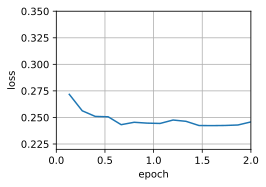

In [5]:
'''
下载并加载"airfoil"数据集（空气动力学数据）
标准化特征：零均值、单位方差
创建数据迭代器：每批10个样本
返回：data_iter：可迭代对象，每次返回(X,y);feature_dim：特征数量（5维）
'''
data_iter, feature_dim = d2l.get_data_ch11(batch_size=10)
d2l.train_ch11(adagrad, init_adagrad_states(feature_dim),
               {'lr': 0.1}, data_iter, feature_dim);

## 简洁实现

我们可直接使用深度学习框架中提供的AdaGrad算法来训练模型。


loss: 0.242, 0.027 sec/epoch


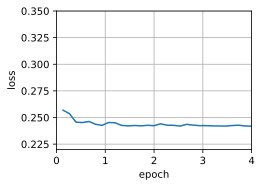

In [6]:
trainer = torch.optim.Adagrad
d2l.train_concise_ch11(trainer, {'lr': 0.1}, data_iter)